# Fold arbitrary fluxes through MagEIS isotropic response functions and compare with the official fluxes

This notebook explores how the flux calculated using the Bayes method compares to the publically avaliable values.

The steps are almost the same as the 2018-06-29_iso_R_arbitrary_spectra notebook, but uses the true MagEIS low count rates.

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [2]:
# Initialize the response function
# RBSP-A MagEIS LOW LUT=16386 from 2016-01-01 (same for all day)
R = mageis_response.R_iso(101, lut=16386, magB=1065)
print('Using MagEIS calibration file: {}'.format(R._cal_file))
E = 1000*R.E # energy array in keV.
n_ch = (1, 9) # Use the main rate channels and ignore the first channel (is it junk?)

Using MagEIS calibration file: /home/msshumko/Documents/mageis-stats/utils/mageis_response_files/low/rbsp_mageis_low_101_1065_MR_16386.mat


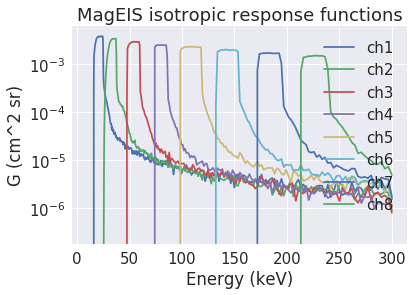

In [3]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS isotropic response functions'); plt.yscale('log');
plt.legend(); #plt.savefig('response.png', dpi=300)

The observed count rates and the official flux from 2016-01-01T00:00:02.823000

In [4]:
c_obs = np.array([33758.242, 30543.17, 17682.889, 12860.282,
       10047.096, 2411.303, 1105.1805, 552.5903]) # Counts/s
FEDU = [1.2161670e+06, 1.1864615e+06, 5.3590431e+05,
        4.5189862e+05, 2.2285083e+05, 5.6950922e+04, 2.7401449e+04,
        1.4226637e+04] # Flux from Channels 1-9 (cm^2 s sr keV)^-1

### Model the energy channel-dependent flux 

In [5]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    # Numpy arrays do not work for this, but lists can store anything (sloppy).
    lams = (n_ch[1]-n_ch[0])*[0] 
    
    for ch in range(*n_ch):
        # Fold the flux through R
        f = pm.math.dot(JJ[ch-n_ch[0]], R.response(ch))
        # Integrate over the folded spectra and keep an MCMC trace.
        lams[ch-n_ch[0]] = pm.Deterministic('lam{}'.format(ch), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=1, upper=1E7, shape=(n_ch[1]-n_ch[0]))

    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_interval__]
 11%|█         | 1142/10500.0 [00:05<00:44, 209.85it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '9790' (I am process '9791')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [00:49<00:00, 211.45it/s]


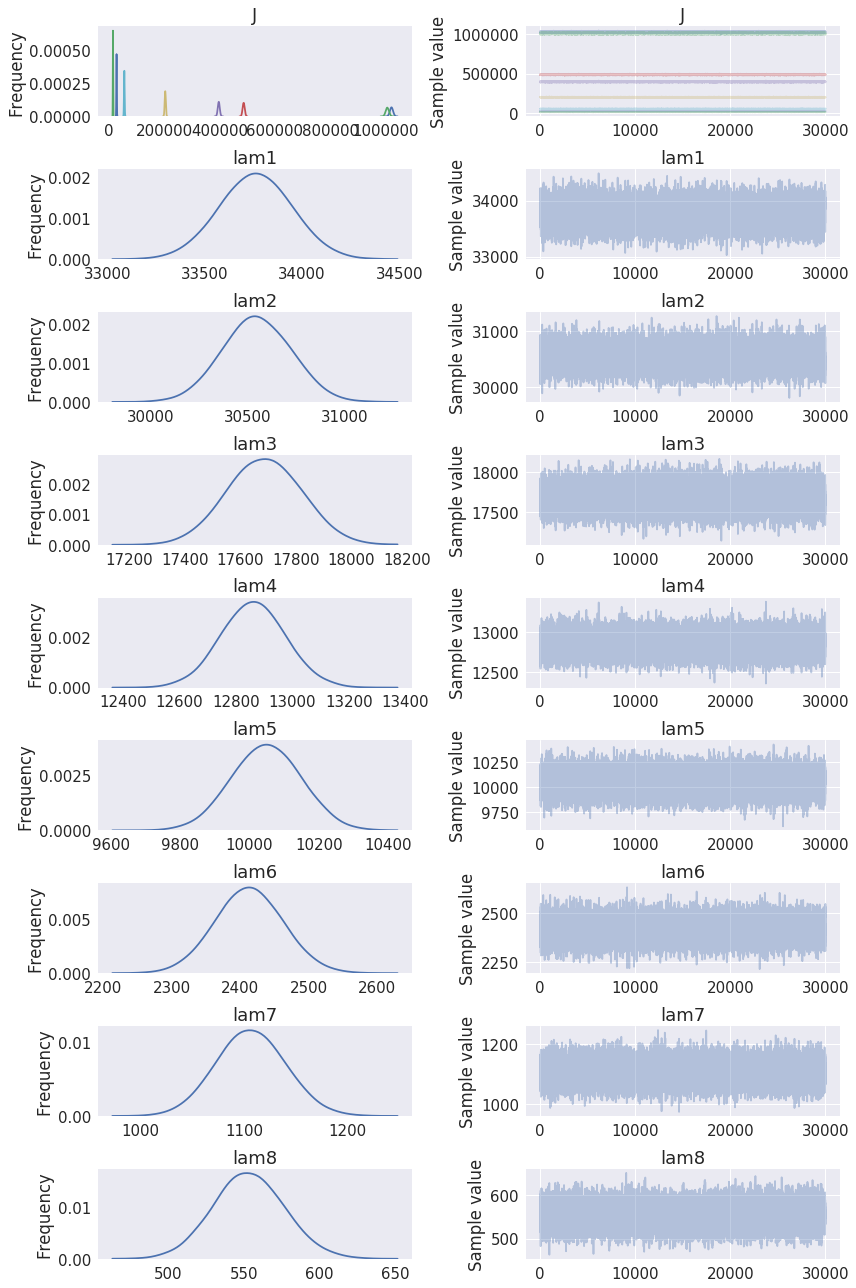

In [15]:
pm.traceplot(trace, combined=True);
#plt.savefig('validation_traceplot.png', dpi=300)

In [7]:
pm.summary(trace)

mean           sd   mc_error       hpd_2.5      hpd_97.5  \
J__0  1.021176e+06  5601.742600  28.668823  1.010525e+06  1.032472e+06   
J__1  1.006200e+06  5781.637105  31.423710  9.950900e+05  1.017534e+06   
J__2  4.865823e+05  3677.703669  18.944449  4.795092e+05  4.938582e+05   
J__3  3.965448e+05  3493.479323  17.872160  3.895426e+05  4.033706e+05   
J__4  2.030234e+05  1994.964750   9.896798  1.992103e+05  2.069439e+05   
J__5  5.496172e+04  1116.020457   5.872855  5.278435e+04  5.716008e+04   
J__6  2.696183e+04   806.604174   4.388654  2.537010e+04  2.851411e+04   
J__7  1.397232e+04   590.615072   3.337595  1.283676e+04  1.515614e+04   
lam1  3.375876e+04   185.186367   0.947754  3.340666e+04  3.413220e+04   
lam2  3.054401e+04   175.506188   0.953892  3.020675e+04  3.088806e+04   
lam3  1.768413e+04   133.660843   0.688509  1.742707e+04  1.794856e+04   
lam4  1.285965e+04   113.290909   0.579581  1.263257e+04  1.308101e+04   
lam5  1.004662e+04    98.720900   0.489743  9.857928e+03  1.024062e+04   
lam6  2.412273e+03    48.982204   0.257760  2.316708e+03  2.508759e+03   
lam7  1.106017e+03    33.088185   0.180030  1.040722e+03  1.169694e+03   
lam8  5.529370e+02    23.372840   0.132081  5.079986e+02  5.997849e+02   

             n_eff      Rhat  
J__0  37504.122233  0.999967  
J__1  39452.328046  0.999974  
J__2  37208.859653  0.999958  
J__3  36577.214202  1.000030  
J__4  39311.563926  1.000019  
J__5  36927.225196  0.999968  
J__6  38977.000742  1.000010  
J__7  34963.277524  1.000011  
lam1  37504.122233  0.999967  
lam2  39452.328046  0.999974  
lam3  37208.859653  0.999958  
lam4  36577.214202  1.000030  
lam5  39311.563926  1.000019  
lam6  36927.225196  0.999968  
lam7  38977.000742  1.000010  
lam8  34963.277524  1.000011

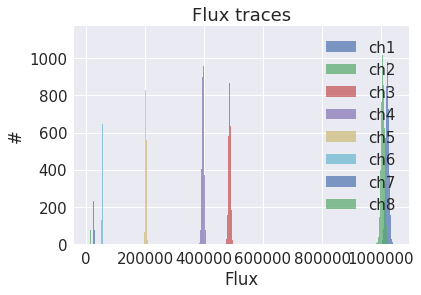

In [8]:
for ch in range(*n_ch):
    plt.hist(trace['J'][:, ch-n_ch[0]], alpha=0.7, bins=100, label='ch{}'.format(ch))
plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [9]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(*n_ch)])

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)
j_ci = np.percentile(trace['J'], (2.5, 97.5), axis=0) 

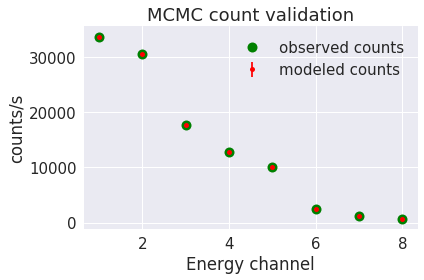

In [17]:
plt.plot(np.arange(*n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(*n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend(); plt.title('MCMC count validation'); plt.xlabel('Energy channel');
plt.ylabel('counts/s'); plt.tight_layout(); #plt.savefig('validation_counts.png', dpi=200)

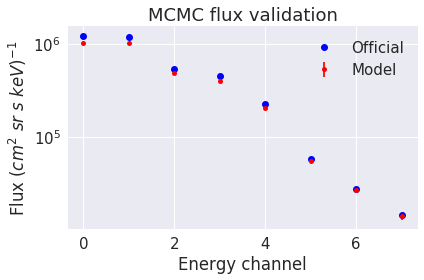

In [19]:
plt.errorbar(np.arange(len(j_mean)), j_mean, 
             fmt='ro', yerr=np.abs(j_ci-j_mean), label='Model', ms=5);
#plt.plot(np.arange(*n_ch), official_flux, 'bo', label='Official')
plt.plot(np.arange((n_ch[1]-n_ch[0])), np.array(FEDU), 'bo', label='Official')
plt.title('MCMC flux validation'); plt.xlabel('Energy channel'); 
plt.ylabel(r'Flux $(cm^2 \ sr \ s \ keV)^{-1}$');
plt.yscale('log'); plt.legend(); 
plt.tight_layout(); #plt.savefig('validation_flux.png', dpi=300)